# Data analysis

## Import dependencies

In [1]:
import os
import json
import numpy as np
import pandas as pd
import random
import zipfile
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import seaborn as sns


## Downloading the data

In [2]:
import kagglehub

path = "/root/.cache/kagglehub/datasets/himanshuwagh/spotify-million/versions/1"
if not os.path.exists(path):
  # Download latest version
  path = kagglehub.dataset_download("himanshuwagh/spotify-million")

  print("Path to dataset files:", path)

100%|██████████| 5.20G/5.20G [01:03<00:00, 87.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/himanshuwagh/spotify-million/versions/1


## What type of data do we have? What do we need?

In [3]:
print(os.listdir(path))

['stats.txt', 'md5sums', 'data', 'README.md', 'src', 'license.txt']


In [4]:
mpdslices_dir: str = os.path.join(path, "data")
shuffled_slices = np.array([f for f in os.listdir(mpdslices_dir) if f.startswith("mpd.slice.") and f.endswith(".json")])
np.random.shuffle(shuffled_slices) # Array disordinato con tutti gli slice

print(mpdslices_dir,
      ':\n [', shuffled_slices[0], ", ... ,", shuffled_slices[-1],']')
print('\nThe dataset is splitted into', np.shape(shuffled_slices)[0],'slices, each one is a JSON files')


/root/.cache/kagglehub/datasets/himanshuwagh/spotify-million/versions/1/data :
 [ mpd.slice.845000-845999.json , ... , mpd.slice.202000-202999.json ]

The dataset is splitted into 1000 slices, each one is a JSON files


In [5]:
es = None
with open(os.path.join(mpdslices_dir, shuffled_slices[0]), 'r') as f:
        es = json.load(f)

In [6]:
print(f'the type of the data extracted is {type(es)}')

the type of the data extracted is <class 'dict'>


Vediamo ora che dati dobbiamo maneggiare:

Dalle documentazioni abbiamo visto che ogni slice è un dizionario con chiavi 'info' e 'playlists'.
che c'è scritto su 'info'?

In [7]:
print(es['info'])

{'generated_on': '2017-12-04 03:05:11.774401', 'slice': '845000-845999', 'version': 'v1'}


Nulla di interessante, ora vediamo 'playlists'

In [8]:
print(type(es))
print(list(es['playlists'][0].keys()))
print(list(es['playlists'][0]['tracks'][0].keys()))
print('\nFirst song of the first playlist:')
es['playlists'][0]['tracks'][0]

<class 'dict'>
['name', 'collaborative', 'pid', 'modified_at', 'num_tracks', 'num_albums', 'num_followers', 'tracks', 'num_edits', 'duration_ms', 'num_artists']
['pos', 'artist_name', 'track_uri', 'artist_uri', 'track_name', 'album_uri', 'duration_ms', 'album_name']

First song of the first playlist:


{'pos': 0,
 'artist_name': 'Russ',
 'track_uri': 'spotify:track:3pndPhlQWjuSoXhcIIdBjv',
 'artist_uri': 'spotify:artist:1z7b1Pr1rSlvWRzsW3HOrS',
 'track_name': 'What They Want',
 'album_uri': 'spotify:album:0lUL92det7mZ4DaHYmiUEC',
 'duration_ms': 165853,
 'album_name': "There's Really A Wolf"}

Segnamoci ora gli attributi che ci interessano (essendo generosi)

In [9]:
keep_p = ['name', 'pid', 'num_tracks', 'num_albums', 'num_followers',
           'num_edits', 'duration_ms', 'num_artists', 'collaborative']
# we still keep 'tracks' but its a special case
keep_t = ['track_name', 'artist_name', 'track_uri']
# this way we only save the useful stuff from the JSON file

## Creating the dataframe

Inizializziamo ora delle variabili utili

In [10]:
num_training_files = 200 # numero di slice che userò
tracks = set() # set che uso per sapere se ho gia inserito la canzone (uso uri)
uri_to_idx = dict() # associo ad ogni uri ad un indice
idx_to_uri = dict() # nel caso mi servisse
coll_enc = {'true':1, 'false':0} # solo per avere valore numerico

Ed ora costruiamo il dataset con la seguente struttura:
* Nelle prime colonne abbiamo le feature contenute in `keep_p`, (di tipo dizionario).
* Nella colonna tracks abbiamo una lista di dizionari
ed ognuno contiene le feature in `keep_t`, (sempre di tipo dizionario).









In [11]:
million_df = pd.DataFrame()
data_list = []

In [12]:
idx = 0
for i, filename in tqdm(enumerate(shuffled_slices[:num_training_files]),
                        desc="Processing Slices",
                        total = num_training_files):
    fp = os.path.join(mpdslices_dir, filename)
    with open(fp, 'r', encoding='utf8') as f:
        data = json.load(f)

        for playlist in data["playlists"]:
            playl = {field : playlist[field] for field in keep_p}
            playl['collaborative'] = coll_enc[playlist['collaborative']]

            tracce = []
            for track in playlist['tracks']:
                song = {field: track[field] for field in keep_t}
                uri = track['track_uri'][14:] # per evitare la parte 'spotify:track:'

                if uri not in tracks:
                    song['track_id'] = idx # sostituisco id uri con nuovo id numerico.
                    tracks.add(uri)        # aggiungo uri alle canzoni totali che ho.
                    uri_to_idx[uri] = idx  # mi salvo la corrispondenza
                    idx_to_uri[idx] = uri  # biunivoca tra uri e indici
                    idx += 1
                else:
                    song['track_id'] = uri_to_idx[uri]
                    # sostituisco id uri con id numerico che gia ho.

                tracce += [song]

            playl['tracks'] = tracce
            data_list += [playl]

    if i%30 == 0:
        new_data = pd.DataFrame(data_list)
        data_list.clear()
        million_df0 = pd.concat([million_df0, new_data], ignore_index=True)

# concateniamo le righe residue che non sono entrate nell'ultimo if
new_data = pd.DataFrame(data_list)
data_list = []
million_df = pd.concat([million_df, new_data], ignore_index=True)

Processing Slices: 100%|██████████| 200/200 [02:13<00:00,  1.50it/s]


In [13]:
os.system(f"rm -rf {mpdslices_dir}")

0

In [14]:
million_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   name           200000 non-null  object
 1   pid            200000 non-null  int64 
 2   num_tracks     200000 non-null  int64 
 3   num_albums     200000 non-null  int64 
 4   num_followers  200000 non-null  int64 
 5   num_edits      200000 non-null  int64 
 6   duration_ms    200000 non-null  int64 
 7   num_artists    200000 non-null  int64 
 8   collaborative  200000 non-null  int64 
 9   tracks         200000 non-null  object
dtypes: int64(8), object(2)
memory usage: 15.3+ MB


In [15]:
#Display the DataFrame
million_df.head()

,name,pid,num_tracks,num_albums,num_followers,num_edits,duration_ms,num_artists,collaborative,tracks
0,hiphop,845000,22,6,1,2,4672623,5,0,"[{'track_name': 'What They Want', 'artist_name..."
1,heart,845001,55,44,1,17,13006155,35,0,"[{'track_name': 'Shooting Star', 'artist_name'..."
2,Teenage Angst,845002,44,39,2,26,9524626,33,0,"[{'track_name': 'Take Me To Church', 'artist_n..."
3,classic rock,845003,178,118,1,57,50484002,73,0,"[{'track_name': 'Carry on Wayward Son', 'artis..."
4,Christmas,845004,34,19,1,6,5459773,14,0,[{'track_name': 'Let It Snow! Let It Snow! Let...


## Data visualization

### Using stats.txt

Cosa dice stats.txt?

In [16]:
stats_path = os.path.join(path, 'stats.txt')
with open(stats_path, 'r') as f:
    stats = f.read()
print(stats)
del stats


number of playlists 1000000
number of tracks 66346428
number of unique tracks 2262292
number of unique albums 734684
number of unique artists 295860
number of unique titles 92944
number of playlists with descriptions 18760
number of unique normalized titles 17381
avg playlist length 66.346428

top playlist titles
  10000 country
  10000 chill
   8493 rap
   8481 workout
   8146 oldies
   8015 christmas
   6848 rock
   6157 party
   5883 throwback
   5063 jams
   5052 worship
   4907 summer
   4677 feels
   4612 new
   4186 disney
   4124 lit
   4030 throwbacks
   3886 music
   3513 sleep
   3500 vibes

top tracks
  46574 HUMBLE. by Kendrick Lamar
  43447 One Dance by Drake
  41309 Broccoli (feat. Lil Yachty) by DRAM
  41079 Closer by The Chainsmokers
  39987 Congratulations by Post Malone
  35202 Caroline by Aminé
  35138 iSpy (feat. Lil Yachty) by KYLE
  34999 Bad and Boujee (feat. Lil Uzi Vert) by Migos
  34990 Location by Khalid
  34922 XO TOUR Llif3 by Lil Uzi Vert
  33699 Bounce 

Ottimo, ora cerchiamo di visualizzare queste informazioni

In [17]:
stats_lines = []
with open(stats_path, 'r') as f:
    stats_lines = f.readlines()

Definiamo una funzione che estrae dalle linee del file i dati che ci servono...

In [20]:
def parse_histogram(stats_lines, start_marker, end_marker=None):
    data = []
    recording = False
    for line in stats_lines:
        if start_marker in line:
            recording = True
            continue
        if end_marker and end_marker in line:
            break
        if recording:
            parts = line.strip().split()
            if len(parts) == 2:
                count, value = int(parts[0]), parts[1]
                data.append((value, count))
            elif len(parts) == 3:  # per gestire i casi "value value count"
                count = int(parts[-1])
                value = " ".join(parts[:-1])
                data.append((value, count))
    return data

# estraiamo gli istogrammi
numedits_histogram = parse_histogram(stats_lines, 'numedits histogram', 'last modified histogram')
last_modified_histogram = parse_histogram(stats_lines, 'last modified histogram', 'playlist length histogram')
playlist_length_histogram = parse_histogram(stats_lines, 'playlist length histogram', 'num followers histogram')
num_followers_histogram = parse_histogram(stats_lines, 'num followers histogram')
print(numedits_histogram)

[('2', 92252), ('3', 81820), ('4', 71973), ('5', 61978), ('6', 53085), ('7', 46860), ('8', 41210), ('9', 36629), ('10', 32810), ('11', 29907), ('12', 26947), ('13', 24941), ('14', 22800), ('15', 20834), ('16', 19000), ('17', 17817), ('18', 16551), ('19', 15305), ('20', 14217), ('21', 13486)]


... Per poi plottarli

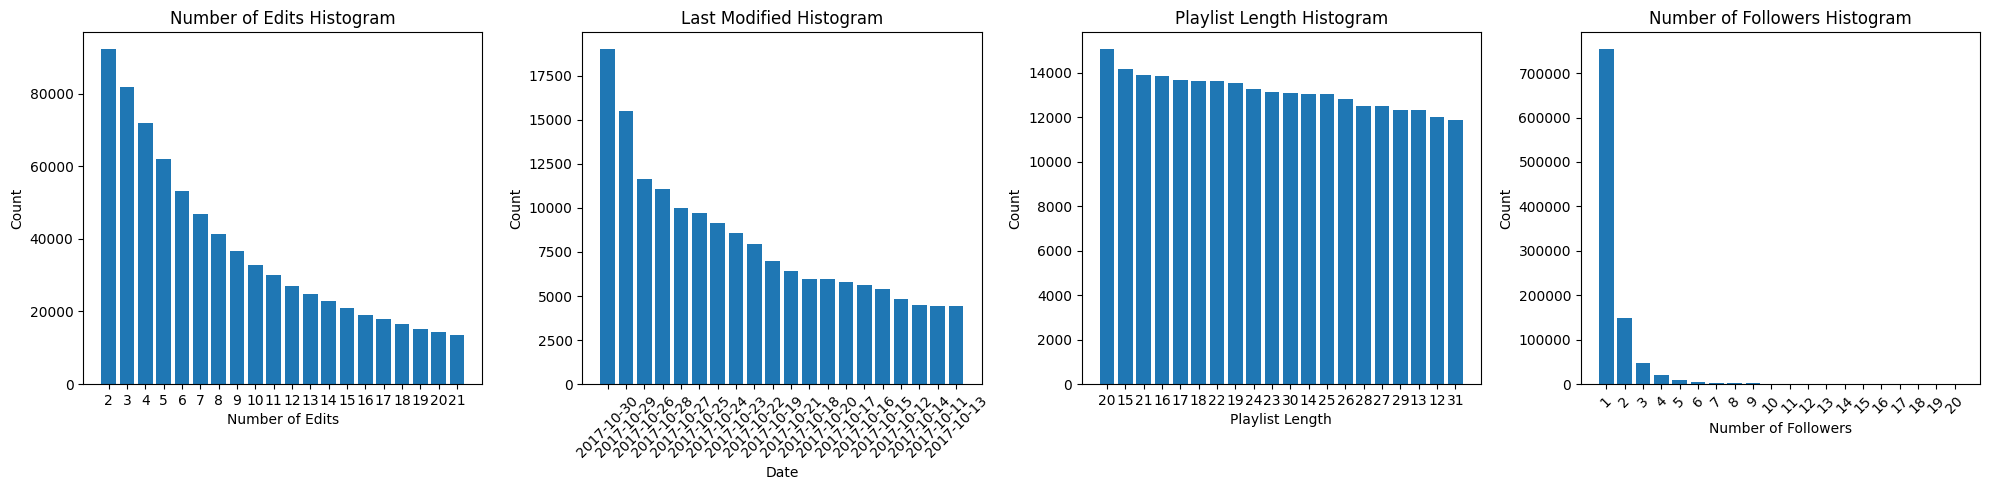

In [21]:
def plot_histograms(histograms, titles, xlabels, ylabels, rotations):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes = axes.flatten()  # in caso avessimo shape diversi della grid dei plot

    for i, ax in enumerate(axes):
        if i < len(histograms):
            data = histograms[i]
            values, counts = zip(*data)
            ax.bar(values, counts, align='center')
            ax.set_title(titles[i])
            ax.set_xlabel(xlabels[i])
            ax.set_ylabel(ylabels[i])
            ax.tick_params(axis='x', rotation=rotations[i])
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# dati utili per il plot
histograms = [numedits_histogram, last_modified_histogram,
              playlist_length_histogram, num_followers_histogram]
titles = ['Number of Edits Histogram','Last Modified Histogram',
          'Playlist Length Histogram','Number of Followers Histogram']
xlabels = ['Number of Edits', 'Date', 'Playlist Length', 'Number of Followers']
ylabels = ['Count', 'Count', 'Count', 'Count']
rotations = [0, 45, 0, 45]

plot_histograms(histograms, titles, xlabels, ylabels, rotations)

### Using the dataframe

Vediamo di capire le caratterisiche e correlazioni del nostro dataframe

In [22]:
million_df.describe()

,pid,num_tracks,num_albums,num_followers,num_edits,duration_ms,num_artists,collaborative
count,200000.000000,200000.000000,200000.000000,200000.00000,200000.000000,2.000000e+05,200000.000000,200000.000000
mean,530599.500000,66.403525,49.673405,2.83126,17.677635,1.558773e+07,38.143555,0.022210
std,277709.108502,53.641619,39.963198,154.32283,20.692542,1.281410e+07,30.281946,0.147366
min,4000.000000,5.000000,2.000000,1.00000,1.000000,4.408010e+05,3.000000,0.000000
25%,294749.750000,26.000000,20.000000,1.00000,5.000000,5.992788e+06,16.000000,0.000000
50%,552499.500000,49.000000,37.000000,1.00000,10.000000,1.142258e+07,30.000000,0.000000
75%,755499.250000,92.000000,68.000000,1.00000,22.000000,2.150100e+07,52.000000,0.000000
max,992999.000000,250.000000,244.000000,53519.00000,201.000000,1.543402e+08,234.000000,1.000000


In [23]:
#Display the DataFrame
million_df.head()

,name,pid,num_tracks,num_albums,num_followers,num_edits,duration_ms,num_artists,collaborative,tracks
0,hiphop,845000,22,6,1,2,4672623,5,0,"[{'track_name': 'What They Want', 'artist_name..."
1,heart,845001,55,44,1,17,13006155,35,0,"[{'track_name': 'Shooting Star', 'artist_name'..."
2,Teenage Angst,845002,44,39,2,26,9524626,33,0,"[{'track_name': 'Take Me To Church', 'artist_n..."
3,classic rock,845003,178,118,1,57,50484002,73,0,"[{'track_name': 'Carry on Wayward Son', 'artis..."
4,Christmas,845004,34,19,1,6,5459773,14,0,[{'track_name': 'Let It Snow! Let It Snow! Let...


Utiliziamo quindi la matrice di correlazione per cercare di estrarre qualche info sulle feature delle playlist, ma prima dobbiamo eliminare colonne non numeriche (e la colonna pid)

In [24]:
df_num = million_df.drop(columns=['name','pid','tracks'])

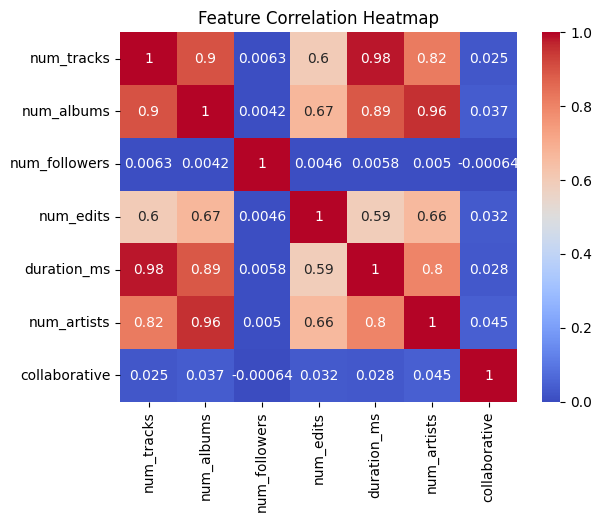

In [25]:
# Correlation heatmap
# Correlation matrix to show relationships between features
sns.heatmap(df_num.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

Non ci stupisce che la durata della playlist `duration_ms`
è molto correlata con il numero di tracce `num_tracks` cosi come con il numero di album `num_albums` e di artisti `num_artists`.

Naturalmente il numero di artisti `num_artists` è altamente correlato al numero di album, ma notiamo una leggera correlazione con il numero di modifiche applicate alla playlist `num_edits`. Questa leggera correlazione con il numero di modifiche si puo trovare anche in tutte le feature sopra nominate.

Infine possiamo notare come le feature `num_followers` e `collaborative` sono quasi completamente scorrelate da tutte le altre feature.

In [26]:
del df_num

Una volta visualizzati i dati in questa maniera, costruiamo una struttura diversa: ogni riga è una coppia `(p_id, track_uri)` tale che la playlist identificata con `pid` contiene la traccia identificata con `track_uri`